## Vanguard Tech ETF Closing Price Prediction

Team members: Soham Deo, Anandhu Mahesh, Pablo Carbajo

In [1]:
import pandas as pd
import seaborn as sns

Our dataset is comprised of the Vanguard Tech ETFs different attributes from January 2004-March 2020. The dataset is a file named 'VGT.csv' that we found on Kaggle with the following features: Opening price, High price, Low price, Closing price, Adjusted Closing Price, and Volume

In [2]:
vgt_df = pd.read_csv('VGT.csv')
vgt_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-01-30,48.740002,49.240002,48.740002,49.080002,42.302021,117600
1,2004-02-02,49.099998,49.119999,48.840000,49.119999,42.336487,65400
2,2004-02-03,48.799999,48.820000,48.619999,48.820000,42.077930,231100
3,2004-02-04,47.500000,47.500000,47.349998,47.349998,40.810925,51000
4,2004-02-05,47.700001,47.700001,47.349998,47.590000,41.017788,2600


The code block below first changes the Date column to be a datetime object which is then set as the index of the DataFrame. Since the specific date is not as important as the season/financial quarter in the context of this problem, we manipulated the index to be set to quarterly periods.

In [3]:
# convert the 'Date' column to a pandas datetime object
vgt_df['Date'] = pd.to_datetime(vgt_df['Date'])

# set the 'Date' column as the dataframe index
vgt_df.set_index('Date', inplace=True)

# convert the index to quarterly periods
vgt_df.index = vgt_df.index.to_period('Q')

# print the modified dataframe
print(vgt_df.head())

             Open       High        Low      Close  Adj Close  Volume
Date                                                                 
2004Q1  48.740002  49.240002  48.740002  49.080002  42.302021  117600
2004Q1  49.099998  49.119999  48.840000  49.119999  42.336487   65400
2004Q1  48.799999  48.820000  48.619999  48.820000  42.077930  231100
2004Q1  47.500000  47.500000  47.349998  47.349998  40.810925   51000
2004Q1  47.700001  47.700001  47.349998  47.590000  41.017788    2600


The functions below are to calculate SMA (simple moving average) and RSI (relative strength index) Upon doing some initial research, we found that these two technical indicators can be useful for predicting closing price of a stock/etf.

In [4]:
def SMA(data, window=20):
    sma = data.rolling(window=window).mean()
    return sma.shift(1)


In [5]:
def RSI(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean().shift(1)
    avg_loss = loss.rolling(window=window).mean().shift(1)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [6]:
vgt_df['RSI'] = RSI(vgt_df['Close'], window=14)
vgt_df['SMA50'] = SMA(vgt_df['Close'], window=50)
vgt_df['SMA200'] = SMA(vgt_df['Close'], window=200)
vgt_df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA50,SMA200
Date,,,,,,,,,
2004Q1,48.740002,49.240002,48.740002,49.080002,42.302021,117600,NaN,NaN,NaN
2004Q1,49.099998,49.119999,48.840000,49.119999,42.336487,65400,NaN,NaN,NaN
2004Q1,48.799999,48.820000,48.619999,48.820000,42.077930,231100,NaN,NaN,NaN
2004Q1,47.500000,47.500000,47.349998,47.349998,40.810925,51000,NaN,NaN,NaN
2004Q1,47.700001,47.700001,47.349998,47.590000,41.017788,2600,NaN,NaN,NaN


The functions result in some initial NaN values. Linear regression cannot take NaN values as input, so we decided to fill the NaN values with the backwards fill method.

In [7]:
# replace NaN RSI values with the next non-NaN value
vgt_df['RSI'].fillna(method='bfill', inplace=True)
# replace NaN SMA50 values with the next non-NaN value
vgt_df['SMA50'].fillna(method='bfill', inplace=True)
# replace NaN RSI values with the next non-NaN value
vgt_df['SMA200'].fillna(method='bfill', inplace=True)
vgt_df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA50,SMA200
Date,,,,,,,,,
2004Q1,48.740002,49.240002,48.740002,49.080002,42.302021,117600,46.421984,47.0058,44.2786
2004Q1,49.099998,49.119999,48.840000,49.119999,42.336487,65400,46.421984,47.0058,44.2786
2004Q1,48.799999,48.820000,48.619999,48.820000,42.077930,231100,46.421984,47.0058,44.2786
2004Q1,47.500000,47.500000,47.349998,47.349998,40.810925,51000,46.421984,47.0058,44.2786
2004Q1,47.700001,47.700001,47.349998,47.590000,41.017788,2600,46.421984,47.0058,44.2786


Used StandardScaler to scale our selected features.

In [8]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA50', 'SMA200']

# create a scaler object
scaler = StandardScaler()

# fit the scaler to the data
scaler.fit(vgt_df[cols_to_scale])
# transform the data using the scaler
scaled_data = scaler.transform(vgt_df[cols_to_scale])

vgt_scaled_df = pd.DataFrame(scaled_data, columns=cols_to_scale, index=vgt_df.index)
vgt_scaled_df.head()

,Open,High,Low,Volume,RSI,SMA50,SMA200
Date,,,,,,,
2004Q1,-0.777226,-0.772972,-0.770630,-0.444301,-0.530295,-0.805061,-0.853709
2004Q1,-0.770513,-0.775194,-0.768751,-0.594406,-0.530295,-0.805061,-0.853709
2004Q1,-0.776107,-0.780750,-0.772884,-0.117924,-0.530295,-0.805061,-0.853709
2004Q1,-0.800351,-0.805195,-0.796737,-0.635814,-0.530295,-0.805061,-0.853709
2004Q1,-0.796621,-0.801491,-0.796737,-0.774992,-0.530295,-0.805061,-0.853709


Correlation heatmap between selected features. Very strong correlations between open, high, low, SMA50 and SMA200 features. This indicates a strong linear relationship. As one goes down so will the other.

<AxesSubplot: >

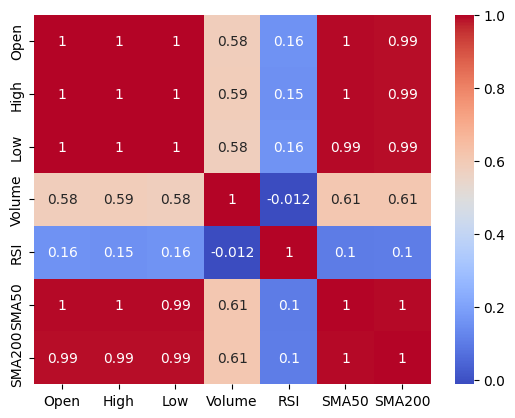

In [9]:
corr_matrix = vgt_scaled_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Identified our target column: Closing price. Now we have extracted features and label column and will split the data into training, testing and validation splits. 

In [10]:
label_df = vgt_df['Close']


In [11]:
vgt_scaled_df.shape

(4071, 7)

In [12]:
label_df.shape

(4071,)

Below is the code to implement train_test_split and create 5 folds of data. k = 5.

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

features = vgt_scaled_df.to_numpy()
label = label_df.to_numpy()
label = np.array(label).reshape(-1, 1)

_x, x_test, _y, y_test = train_test_split(features, label, test_size=0.10, random_state=42)

# set k = 5
k = 5

kfold_spliiter = KFold(n_splits=k)

folds_data = [] # this is an inefficient way but still do it

fold = 1
for train_index, validation_index in kfold_spliiter.split(_x):
    x_train, x_valid = _x[train_index,:], _x[validation_index,:]
    y_train, y_valid = _y[train_index], _y[validation_index]
    print(f"Fold {fold} training data shape = {(x_train.shape,y_train.shape)}")
    print(f"Fold {fold} validation data shape = {(x_valid.shape,y_valid.shape)}")
    fold += 1
    folds_data.append((x_train,y_train,x_valid,y_valid))

Fold 1 training data shape = ((2930, 7), (2930, 1))
Fold 1 validation data shape = ((733, 7), (733, 1))
Fold 2 training data shape = ((2930, 7), (2930, 1))
Fold 2 validation data shape = ((733, 7), (733, 1))
Fold 3 training data shape = ((2930, 7), (2930, 1))
Fold 3 validation data shape = ((733, 7), (733, 1))
Fold 4 training data shape = ((2931, 7), (2931, 1))
Fold 4 validation data shape = ((732, 7), (732, 1))
Fold 5 training data shape = ((2931, 7), (2931, 1))
Fold 5 validation data shape = ((732, 7), (732, 1))


The code block below is the configuration and training of our various regression models. Linear regression, SVRs (linear and poly kernel), XGBRegressor, GradientBoostingRegressor and DecisionTreeRegressor. For regression models, the evaluation metric is MSE and MAE, and we calculated the MSE and MAE for each fold and output the average training and validation MSE and MAE across all folds. 

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the models
all_models = {
    'linear_regression': LinearRegression(),
    'svr_linear_kernel': SVR(kernel='linear'),
    'svr_poly_kernel': SVR(kernel='poly'),
    'xgboost_regressor': XGBRegressor(objective='reg:squarederror'),
    'gradient_boosting_regressor': GradientBoostingRegressor(),
    'decision_tree': DecisionTreeRegressor()
}

best_validation_mae = float('inf')
best_validation_mse = float('inf')
best_model_name = ""
best_model = None

# Iterate over all models
for model_name in all_models.keys():
    print(f"")
    print(f"Evaluating {model_name} ...")
    model = all_models[model_name]

    # Let's store training and validation MAE and MSE for all folds
    train_mae_for_all_folds = []
    valid_mae_for_all_folds = []
    train_mse_for_all_folds = []
    valid_mse_for_all_folds = []

    # Store actual and predicted values for each fold
    actual_predicted_values = []

    # Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold

        # Train the model
        _ = model.fit(x_train, y_train.flatten())

        # Evaluate the model on training data
        y_pred_train = model.predict(x_train)

        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)

        # Store actual and predicted values for each fold
        actual_predicted_values.append((y_valid.flatten(), y_pred_valid))

        # Compute training MAE and MSE
        train_mae = mean_absolute_error(y_train.flatten(), y_pred_train)
        train_mse = mean_squared_error(y_train.flatten(), y_pred_train)

        # Store training MAE and MSE for each fold
        train_mae_for_all_folds.append(train_mae)
        train_mse_for_all_folds.append(train_mse)

        # Compute validation MAE and MSE
        valid_mae = mean_absolute_error(y_valid.flatten(), y_pred_valid)
        valid_mse = mean_squared_error(y_valid.flatten(), y_pred_valid)

        # Store validation MAE and MSE for each fold
        valid_mae_for_all_folds.append(valid_mae)
        valid_mse_for_all_folds.append(valid_mse)

    # Average training MAE and MSE across k folds
    avg_training_mae = sum(train_mae_for_all_folds) / k
    avg_training_mse = sum(train_mse_for_all_folds) / k

    print(f"Average training MAE for model {model_name} = {avg_training_mae}")
    print(f"Average training MSE for model {model_name} = {avg_training_mse}")

    # Average validation MAE and MSE across k folds
    avg_validation_mae = sum(valid_mae_for_all_folds) / k
    avg_validation_mse = sum(valid_mse_for_all_folds) / k

    print(f"Average validation MAE for model {model_name} = {avg_validation_mae}")
    print(f"Average validation MSE for model {model_name} = {avg_validation_mse}")

    # Select best model based on average validation MAE and MSE
    if avg_validation_mae < best_validation_mae and avg_validation_mse < best_validation_mse:
        best_validation_mae = avg_validation_mae
        best_validation_mse = avg_validation_mse
        best_model_name = model_name
        best_model = model

print(f"")
print(f'The best model is {best_model_name} with an average validation mae of {best_validation_mae} and an average validation mse of {best_validation_mse}.')
   




Evaluating linear_regression ...
Average training MAE for model linear_regression = 0.29432028640928587
Average training MSE for model linear_regression = 0.3391115294903462
Average validation MAE for model linear_regression = 0.2974910877981012
Average validation MSE for model linear_regression = 0.37180373149251356

Evaluating svr_linear_kernel ...
Average training MAE for model svr_linear_kernel = 0.41639028225371383
Average training MSE for model svr_linear_kernel = 0.5509309482172777
Average validation MAE for model svr_linear_kernel = 0.41724245334852544
Average validation MSE for model svr_linear_kernel = 0.55363701095769

Evaluating svr_poly_kernel ...
Average training MAE for model svr_poly_kernel = 20.715024449422465
Average training MSE for model svr_poly_kernel = 824.1431419858139
Average validation MAE for model svr_poly_kernel = 21.16964020836491
Average validation MSE for model svr_poly_kernel = 883.9394544083143

Evaluating xgboost_regressor ...
Average training MAE fo

Linear Regression was our best model due to the lowest average validation MAE and MSE. The MAE of 0.298 indicates that on average, our model's prediction deviated by that number from the actual. Another valuable metric for regression models is Pearson Correlation which measures the strength of a linear relationship between two variables. Each model except for svr_poly_kernel has a very strong correlation at 0.99, indicating that our model can be useful for predicing closing price of the Vanguard ETF.

In [15]:
import numpy as np
from scipy.stats import pearsonr

# loop over all the models and calculate the Pearson correlation coefficient
for model_name, model in all_models.items():
    y_test = y_test.flatten()
    # fit the model and make predictions
    y_pred = model.predict(x_test)
    
    # calculate the Pearson correlation coefficient between the predicted values and the actual values
    corr, _ = pearsonr(y_test, y_pred)
    
    # print the correlation coefficient for each model
    print(f"Pearson correlation for {model_name}: {corr}")


Pearson correlation for linear_regression: 0.99989718375882
Pearson correlation for svr_linear_kernel: 0.9999162425172007
Pearson correlation for svr_poly_kernel: 0.8442840088865557
Pearson correlation for xgboost_regressor: 0.9998525298886041
Pearson correlation for gradient_boosting_regressor: 0.9998465622544744
Pearson correlation for decision_tree: 0.9998239679810902


## LSTM Implementation

Our group decided to see if we could configure a neural network that works better than our best regression model. Below is the configuration. 

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define hyperparameters
n_steps = 7
n_features = 1
n_epochs = 20
batch_size = 10

# Define the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


# Fit the model
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid))

# Evaluate the model
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test loss:', score)

# Make predictions
predictions = model.predict(x_test)

2023-04-26 17:25:11.478706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 17:25:11.611772: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 17:25:11.618344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 17:25:11.618367: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Some additional data analysis to find the anomalous points using Kmeans clustering to find anomalies. 

In [17]:
#Finding Anomalous Points
from sklearn.cluster import KMeans
import numpy as np

# Choosing the features to use for anomaly detection
features = ['Open', 'High', 'Low', 'Volume', 'RSI', 'SMA50', 'SMA200']

# Create the input data
X = vgt_df[features].values

# Apply the unsupervised algorithm (KMeans)
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

# Get the labels and distances for each data point
labels = kmeans.labels_
distances = np.min(kmeans.transform(X), axis=1)


# Choose the top M anomalous points
M = 5
anomalous_indices = np.argsort(distances)[-M:]
anomalous_points = vgt_df.iloc[anomalous_indices]

# Print the anomalous points
print(anomalous_points)

              Open        High         Low       Close   Adj Close   Volume  \
Date                                                                          
2018Q4  172.270004  173.190002  167.610001  168.869995  166.115738  3788100   
2020Q1  189.279999  198.000000  183.009995  194.690002  194.690002  3809500   
2018Q3  200.320007  202.350006  200.320007  202.220001  197.565445  3916000   
2019Q1  169.070007  169.690002  166.940002  169.039993  166.282959  4256000   
2018Q1  179.220001  179.610001  177.970001  178.910004  173.956909  6564500   

              RSI       SMA50     SMA200  
Date                                      
2018Q4  50.729378  183.310400  185.40370  
2020Q1  37.897011  250.243000  227.89005  
2018Q3  74.041291  189.769401  178.01505  
2019Q1  44.632988  176.011199  184.27475  
2018Q1  71.892799  172.326399  157.36850  


These are the quarters that VGT behaved most strongly from the period of January 2004 to March 2020

## Feature Ablation

Ran feature ablation test to rank feature importance. First block shows that as you remove Open, High and Low as features, the MAE increases significantly indicating that dropping those features negatively affects model performance. The feature ablation bar graph reiterates this.

In [18]:
# Let's run ablation tests on our best model
# You could choose any model to do this test

feature_names = vgt_scaled_df.columns

# Let's maintain an MAE dictionary
mae_drop_log = {"No ablation":0}

for i in range(len(feature_names)):
    # we are going to drop one feature at a time
    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")
    
    # Remmeber? We have the train + valid data in the above section?
    # We just remove the feature by not selecting the column from the index i

    x_ablated = np.delete(_x, i, axis=1) # axis = 1 means columns
    
    cv_scores = cross_validate(best_model, x_ablated, _y.flatten(), cv=k, scoring='neg_mean_absolute_error', n_jobs=4)
    average_cv_score = -cv_scores['test_score'].mean()
    print (f"Mean cross validation MAE = {average_cv_score}")
    mae_drop_log[feature_name] = best_validation_mae - average_cv_score


Removing feature Open
Mean cross validation MAE = 0.3776567970923672
Removing feature High
Mean cross validation MAE = 0.43746934425377565
Removing feature Low
Mean cross validation MAE = 0.4545262923318715
Removing feature Volume
Mean cross validation MAE = 0.2965660375622665
Removing feature RSI
Mean cross validation MAE = 0.2973559825674853
Removing feature SMA50
Mean cross validation MAE = 0.29458925010417947
Removing feature SMA200
Mean cross validation MAE = 0.2972866241157444


Text(0.5, 1.0, 'Feature Ablation To Rank Importance')

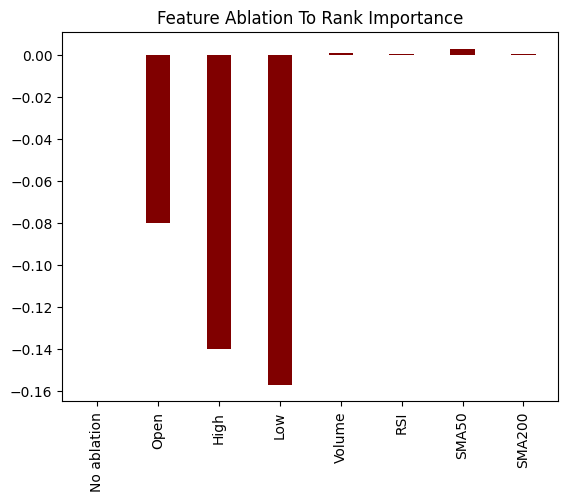

In [19]:
from matplotlib import pyplot as plt

plt.bar(mae_drop_log.keys(), mae_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")
plt.title('Feature Ablation To Rank Importance')

We found it slightly surprising that the SMA features scored so poorly on the ablation test, since they are very close reflections of closing price. (Average closing price over 50, 200 days)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e35eaa9-ecc0-40d6-9e51-dcc41fb702d2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>